## RLDMUU 2025
#### Model based RL
jakub.tluczek@unine.ch

In today's lab we are going to take a look at a model-based algorithm, introduced by Sutton & Barto. We can divide each iteration in 3 steps: 

- Performing classic Q-Learning update and acting $\epsilon$-greedily on an environment
- Updating the environment model $\mu$
- Planning, that is updating the Q-values according to the existing model

In [3]:
import numpy as np
from tqdm import tqdm

In [4]:
import gymnasium as gym

env = gym.make('FrozenLake-v1')

In [5]:
state, info = env.reset()
# useful for checking if the environment terminated
done = False

In [6]:
class DynaQ:
    def __init__(self, n_states, n_actions, alpha, gamma, epsilon, planning):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma 
        self.epsilon = epsilon 
        self.planning = planning

        self.Q = np.zeros((n_states, n_actions))
        self.mu = np.zeros((n_states, n_actions, 2), dtype=int) # For each (s,a) pair, the model outputs (r, s')
        self.N = np.zeros((n_states, n_actions))

    def act(self, state):
        # act greedily
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.n_actions)
        else:
            max_idxs = np.argwhere(self.Q[state,:] == np.amax(self.Q[state,:])).flatten()
            return np.random.choice(max_idxs)
        

    def update(self, state, action, reward, next_state):
        # update the count
        self.N[state, action] += 1
        # update the Q table 

        self.Q[state, action] += self.alpha * (reward + self.gamma * np.max(self.Q[next_state, :]) - self.Q[state, action])
        
        # update the model 
        self.mu[state, action, 0] = reward
        self.mu[state, action, 1] = next_state

        # plan
        for _ in range(self.planning):
            # get previously visited states (i.e. non zero N table rows)
            visited_states = np.where(np.any(self.N != 0, axis=1))[0]
            # randomly sample a previously visited s
            s = np.random.choice(visited_states)
            # get previously played actions for this state
            visited_actions = np.where(self.N[s, :] != 0)[0]
            # randomly sample an action for this state
            a = np.random.choice(visited_actions)
            # get the reward and next state from the model for this (s,a) pair
            r, next_s = self.mu[s, a]
            # update the Q table 
            self.Q[s, a] += self.alpha * (r + self.gamma * np.max(self.Q[next_s, :]) - self.Q[s, a])


    def reset(self):
        self.Q = np.zeros((self.n_states, self.n_actions))
        self.mu = np.zeros((self.n_states, self.n_actions, 2)) # For each (s,a) pair, the model outputs (r, s')
        self.N = np.zeros((self.n_states, self.n_actions))

In [12]:
EPISODES = 10_000
ITERATIONS = 100
PLANNING_STEPS = 5

ALPHA = 0.001
GAMMA = 0.9
EPSILON = 0.1

nsteps = np.ones(EPISODES) * ITERATIONS
mean_episode_rewards = np.zeros(EPISODES)

algo = DynaQ(env.observation_space.n, env.action_space.n, ALPHA, GAMMA, EPSILON, PLANNING_STEPS)

for e in tqdm(range(EPISODES)):
    for i in range(ITERATIONS):
        action = algo.act(state)
        next_state, reward, done, truncated, info = env.step(action)
        algo.update(state, action, reward, next_state)

        if done or truncated:
            state, info = env.reset()
            done = False
            truncated = False
            if reward == 1:
                nsteps[e] = i 
                mean_episode_rewards[e] = 1 / i
            break

        state = next_state

100%|██████████| 10000/10000 [01:48<00:00, 91.91it/s]


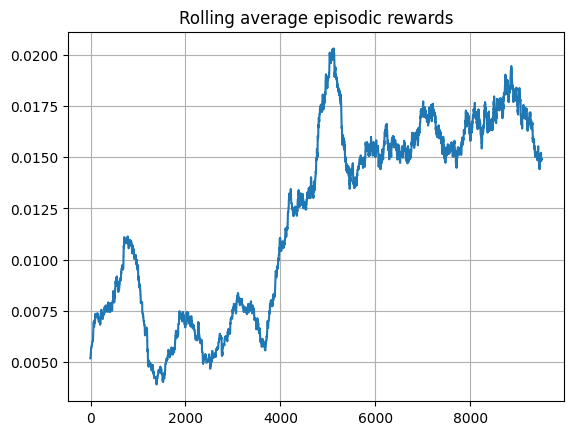

In [13]:
from matplotlib import pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(running_mean(mean_episode_rewards, 500))
plt.title("Rolling average episodic rewards")
plt.grid()
